## **<h3 align="center"> Deep Learning - Project </h3>**
# **<h3 align="center">Preprocessing</h3>**
**Group 4 members:**<br>
Alexandra Pinto - 20211599@novaims.unl.pt - 20211599<br>
Steven Carlson - 20240554@novaims.unl.pt - 20240554<br>
Sven Goerdes - 20240503@novaims.unl.pt - 20240503<br>
Tim Straub - 20240505@novaims.unl.pt - 20240505<br>
Zofia Wojcik  - 20240654@novaims.unl.pt - 20240654<br>

# Table of Contents
* [1. Introduction](#intro)
* [2. Setup](#setup)
* [3. Data Loading and Exploration](#dataloadandexpl)
    * [3.1. Data Loading](#data_loading)
    * [3.2. Validating File Paths](#val_file_path)
    * [3.3. Checking for Missing or Duplicate Values](#NaN_and_duplicates)
    * [3.4. Visualization](#visualization)
* [4. Train Test Split](#train_test_split)
* [5. Image Preprocessing](#image_preproc)


    



In [9]:
#we can also connect to drive and have the images there 

# 1. Introduction <a class="anchor" id="intro"></a>

This project focuses on developing a deep learning model to classify rare species based on images. The dataset comes from the Encyclopedia of Life (EOL) and is curated as part of the *BioCLIP: A Vision Foundation Model for the Tree of Life* study. The full study is available in our repository [here](<Project Description/BioCLIP_study.pdf>).  
In this notebook, we will focus on setting up the environment and preprocessing the data. This includes loading the dataset, exploring its structure, splitting it into training, validation, and test sets, and applying necessary image transformations. These steps are crucial for ensuring that the model is trained effectively and generalizes well to new data.  

# 2. Setup <a class="anchor" id="setup"></a>
In this section, we will import the necessary libraries that will be used throughout the notebook. These libraries will help with data handling and image processing.

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import zipfile
import seaborn as sns

# Libraries for image processing
from glob import glob
from PIL import Image

# 3. Data Loading & Exploration <a class="anchor" id="dataloadandexpl"></a>

## 3.1. Data Loading <a class="anchor" id="data_loading"></a>
In this section, we'll start by unzipping the dataset and loading the metadata CSV file. This allows us to explore the data and validate the image paths.

In [2]:
# Defining the paths
zip_path = "rare_species 1.zip"
extract_path = "rare_species"
csv_path = os.path.join(extract_path, "metadata.csv")  # Update this if the CSV has a different name

# Extract the ZIP file 
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

Now that we already extract the zip file let's check the metadata as well as checking the path.

In [3]:
# Load metadata CSV
df = pd.read_csv(csv_path, index_col="rare_species_id")
print("Metadata Loaded:")
df.head()

Metadata Loaded:


,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
rare_species_id,,,,,,
75fd91cb-2881-41cd-88e6-de451e8b60e2,12853737,449393,animalia,mollusca,unionidae,mollusca_unionidae/12853737_449393_eol-full-si...
28c508bc-63ff-4e60-9c8f-1934367e1528,20969394,793083,animalia,chordata,geoemydidae,chordata_geoemydidae/20969394_793083_eol-full-...
00372441-588c-4af8-9665-29bee20822c0,28895411,319982,animalia,chordata,cryptobranchidae,chordata_cryptobranchidae/28895411_319982_eol-...
29cc6040-6af2-49ee-86ec-ab7d89793828,29658536,45510188,animalia,chordata,turdidae,chordata_turdidae/29658536_45510188_eol-full-s...
94004bff-3a33-4758-8125-bf72e6e57eab,21252576,7250886,animalia,chordata,indriidae,chordata_indriidae/21252576_7250886_eol-full-s...


## 3.2. Validating File Paths <a class="anchor" id="val_file_path"></a>
The file paths in the dataset follow a specific structure based on the metadata columns. We will check that the file paths match this expected format:

- The folder name in the path should be a combination of the phylum and family.
- The filename should consist of the eol_content_id and eol_page_id.

In [4]:
# Function to check if file_path matches expected format
def validate_file_paths(df):
    mismatches = []
    
    for idx, row in df.iterrows():
        # Extract expected components
        expected_folder = f"{row['phylum']}_{row['family']}"
        expected_filename = f"{row['eol_content_id']}_{row['eol_page_id']}"

        # Extract actual components from file_path
        actual_parts = row["file_path"].split("/")
        
        if len(actual_parts) != 2:  # Ensure it follows the expected structure
            mismatches.append((idx, "Invalid path structure"))
            continue
        
        actual_folder, actual_filename = actual_parts
        actual_filename = actual_filename.split("_eol-")[0]  # Remove trailing parts

        # Check for mismatches
        if actual_folder != expected_folder or actual_filename != expected_filename:
            mismatches.append((idx, actual_folder, expected_folder, actual_filename, expected_filename))

    # Convert results to DataFrame for easy review
    if mismatches:
        mismatch_df = pd.DataFrame(mismatches, columns=["Index", "Actual Folder", "Expected Folder", "Actual Filename", "Expected Filename"])
        print("⚠️ Mismatches Found:")
        display(mismatch_df)
    else:
        print("✅ All file paths match the expected format.")

# Run validation
validate_file_paths(df)


✅ All file paths match the expected format.


## 3.3. Checking for Missing or Duplicate Values <a class="anchor" id="NaN_and_duplicates"></a>

In this section, we will check for missing values and duplicates in the metadata.

In [5]:
df.describe(include="O")

,kingdom,phylum,family,file_path
count,11983,11983,11983,11983
unique,1,5,202,11983
top,animalia,chordata,dactyloidae,chordata_lemuridae/9465817_326525_eol-full-siz...
freq,11983,9952,300,1


In [6]:
# Check for duplicate values
print("\nNumber of duplicate rows:")
df.duplicated().sum()


Number of duplicate rows:


np.int64(0)


Missing Values: There are no missing values in the dataset.

Duplicates: There are no duplicate rows in the metadata. Each row is unique based on the rare_species_id index.

Value Distribution: By checking the frequency of the most common values in each column, we can observe how the categories are distributed.

Given that the data is clean (no missing values, no duplicates), we can now proceed to explore the distribution of our data visually to better understand the representation of species across different categories such as phylum and family.

## 3.4. Visualization <a class="anchor" id="visualization"></a>

Visualization is crucial in understanding  metadata. <br>

In [7]:
def plot_count_with_annotations(data, column, top_n=20, bottom_n=False, figsize=(6, 4)):
    '''
    Plot the distribution of classes in a specified column of a DataFrame, showing the top or bottom N classes.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to plot.
    column (str): The column in the DataFrame for which the distribution will be plotted.
    top_n (int, optional): The number of top classes to display. Default is 20.
    bottom_n (bool, optional): Whether to show the bottom N classes instead of top N. Default is False.
    figsize (tuple, optional): The size of the figure (width, height). Default is (6, 4).
    
    Returns:
    None (displays the plot)
    '''
    # Get class counts
    class_counts = data[column].value_counts()
    
    # Get top N or bottom N classes
    if bottom_n:
        class_counts = class_counts.tail(top_n)  # bottom N
    else:
        class_counts = class_counts.head(top_n)  # top N
    
    plt.figure(figsize=figsize)
    ax = sns.barplot(x=class_counts.index, y=class_counts.values)
    
    # Add annotations for each bar
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',  # Format count without decimals
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='center', 
                        xytext=(0, 5), textcoords='offset points')
    
    plt.title(f'Top {top_n} {column} Classes' if not bottom_n else f'Bottom {top_n} {column} Classes')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)
    plt.show()

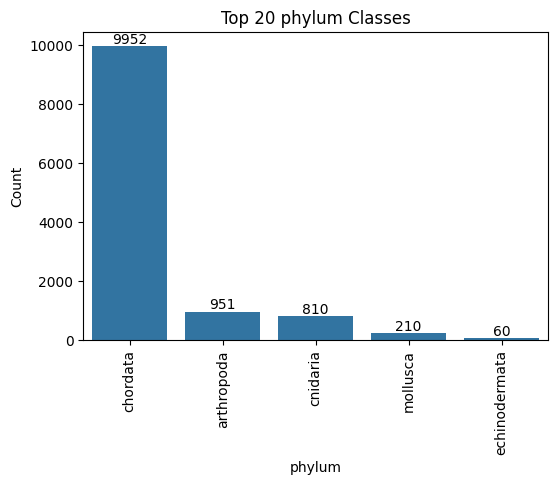

In [8]:
# Visualize the distribution of species across different phyla
plot_count_with_annotations(df, 'phylum', figsize=(6, 4))

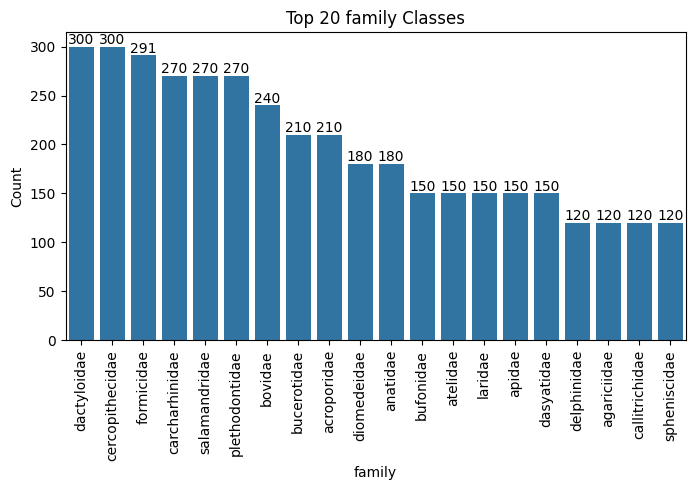

In [11]:
# Plot the top 20 families
plot_count_with_annotations(df, 'family', top_n=20, figsize=(8, 4))

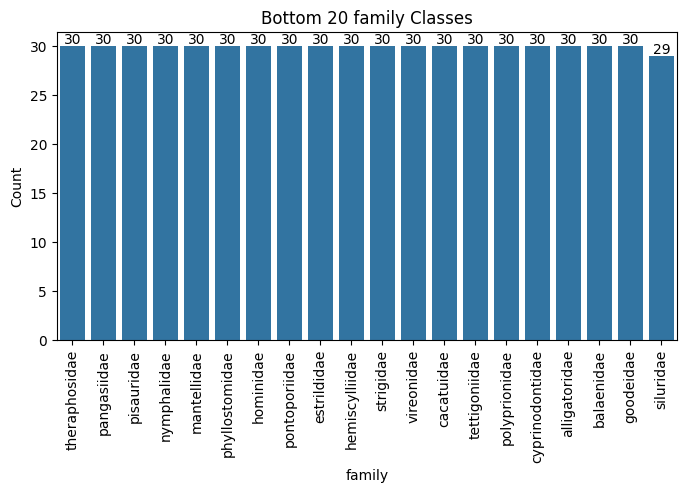

In [13]:
# Plot the bottom 20 families
plot_count_with_annotations(df, 'family', top_n=20, bottom_n=True, figsize=(8, 4))

We can also explore the distribution of family inside each phylum. 

In [ ]:
def print_unique_families_per_phylum(data, phylum_column='phylum', family_column='family'):
    '''
    Print the count of unique families per phylum.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data.
    phylum_column (str, optional): The column for the phylum. Default is 'phylum'.
    family_column (str, optional): The column for the family. Default is 'family'.
    
    Returns:
    None (prints the counts)
    '''
    unique_families_per_phylum = data.groupby(phylum_column)[family_column].nunique()
    print("Unique Families per Phylum:")
    print(unique_families_per_phylum)

print_unique_families_per_phylum(df)

Unique Families per Phylum:
phylum
arthropoda        17
chordata         166
cnidaria          13
echinodermata      1
mollusca           5
Name: family, dtype: int64


In [19]:
def plot_family_distribution_by_phylum(data, phylum_column='phylum', family_column='family', 
                                       selected_phylum=None, top_n=20, figsize=(6, 4)):
    '''
    Plot the distribution of families within each phylum. 
    For a specific phylum (selected_phylum), show top N families, otherwise, show all families.
    
    Parameters:
    data (DataFrame): The DataFrame containing the data to plot.
    phylum_column (str, optional): The column for the phylum. Default is 'phylum'.
    family_column (str, optional): The column for the family. Default is 'family'.
    selected_phylum (str, optional): The phylum for which to display top N families. Default is None (show all).
    top_n (int, optional): Number of top families to display for the selected phylum. Default is 20.
    figsize (tuple, optional): The size of the figure (width, height). Default is (12, 8).
    
    Returns:
    None (displays the plot)
    '''
    # Filter data for the selected phylum (if provided)
    if selected_phylum:
        selected_phylum_data = data[data[phylum_column] == selected_phylum]
        family_counts = selected_phylum_data[family_column].value_counts()

        # Get top N families for the selected phylum
        top_families = family_counts.head(top_n).index
        
        # Filter data for top N families of selected phylum
        filtered_data = selected_phylum_data[selected_phylum_data[family_column].isin(top_families)]
        
        # Plot top N families for selected phylum
        plt.figure(figsize=figsize)
        sns.countplot(data=filtered_data, x=family_column, order=top_families, color='skyblue')
        
        # Add count labels above each bar
        for p in plt.gca().patches:
            height = p.get_height()
            if height > 0:
                plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

        plt.title(f'Families in Phylum {selected_phylum}')
        plt.xlabel(family_column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()
    
    else:
        # For all phyla, plot distribution without filtering top N
        plt.figure(figsize=figsize)
        sns.countplot(data=data, x=family_column, hue=phylum_column, color='skyblue')

        # Add count labels above each bar
        for p in plt.gca().patches:
            height = p.get_height()
            if height > 0:
                plt.gca().annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                                   ha='center', va='center', xytext=(0, 5), textcoords='offset points')

        plt.title('Family Distribution Across All Phyla')
        plt.xlabel(family_column)
        plt.ylabel('Count')
        plt.xticks(rotation=90)
        plt.tight_layout()
        plt.show()

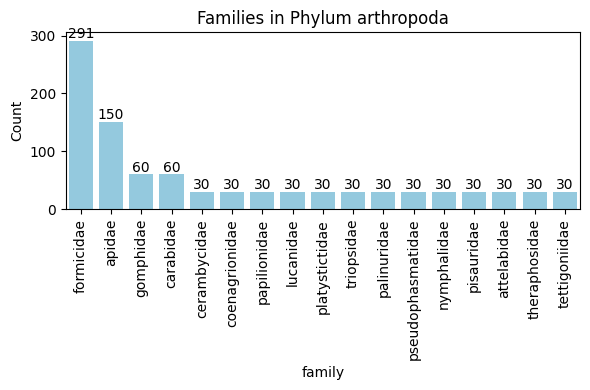

In [20]:
plot_family_distribution_by_phylum(df, selected_phylum="arthropoda")

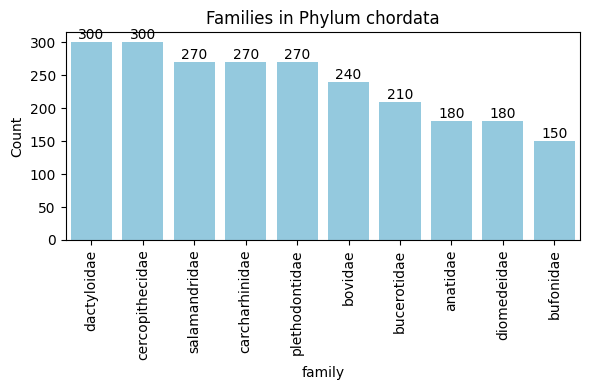

In [21]:
plot_family_distribution_by_phylum(df, selected_phylum="chordata", top_n=10)

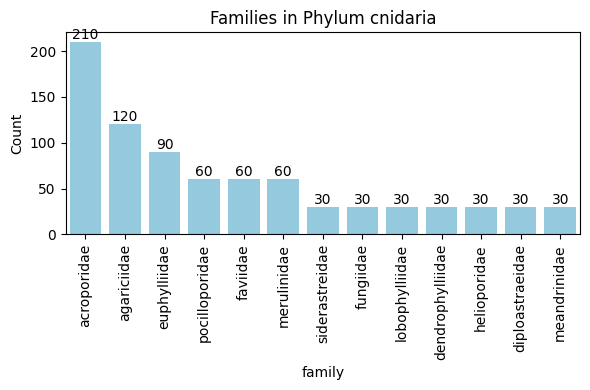

In [22]:
plot_family_distribution_by_phylum(df, selected_phylum="cnidaria")

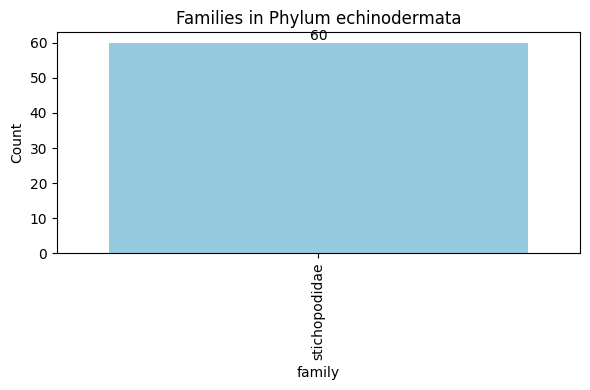

In [23]:
plot_family_distribution_by_phylum(df, selected_phylum="echinodermata")

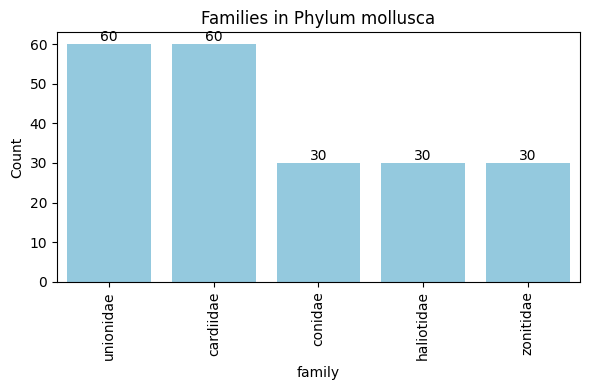

In [24]:
plot_family_distribution_by_phylum(df, selected_phylum="mollusca")

# 4. Train Test Split  <a class="anchor" id="train_test_split"></a>

In [7]:
from pathlib import Path
from keras.utils import image_dataset_from_directory

In [11]:
import os
import shutil
import random
from pathlib import Path

# Define paths
root_dir = Path(".")  # Root directory where the dataset exists
source_dir = root_dir / "rare_species"  # The original dataset (kept untouched)
split_dir = root_dir / "data_splits"  # New directory for partitions

# Paths for train/val/test
train_dir = split_dir / "train"
val_dir = split_dir / "val"
test_dir = split_dir / "test"

# Define split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Create train, val, and test directories in the new dataset folder
for subdir in [train_dir, val_dir, test_dir]:
    subdir.mkdir(parents=True, exist_ok=True)

# Iterate over each species folder
for species in os.listdir(source_dir):
    species_path = source_dir / species
    if not species_path.is_dir():
        continue  # Skip files, only process directories
    
    # Get all images in the species folder
    images = list(species_path.glob("*"))  # Assumes all files inside are images
    random.shuffle(images)  # Shuffle images for randomness

    # Compute split sizes
    train_size = int(len(images) * train_ratio)
    val_size = int(len(images) * val_ratio)

    # Assign images to train, val, and test
    train_images = images[:train_size]
    val_images = images[train_size:train_size + val_size]
    test_images = images[train_size + val_size:]

    # Create species folders inside train/val/test
    for dest_dir, img_list in zip([train_dir, val_dir, test_dir], [train_images, val_images, test_images]):
        class_dir = dest_dir / species
        class_dir.mkdir(parents=True, exist_ok=True)  # Create species folder

        # Copy images instead of moving
        for img in img_list:
            shutil.copy(img, class_dir / img.name)  # Copy to new location

print("New dataset created in 'data_splits/'")


New dataset created in 'data_splits/'


In [6]:
n_classes = 202
batch_size = 64
input_shape = (224, 224, 3)
image_size = (224, 224)
value_range = (0.0, 1.0)

In [12]:
train_dir

WindowsPath('data_splits/train')

In [13]:
train_ds = image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    verbose=False
)

In [14]:
val_ds = image_dataset_from_directory(
    val_dir,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

In [15]:
test_ds = image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=image_size,
    interpolation="bilinear",
    shuffle=False,
    verbose=False
)

# only a test to see if this is working or not - this code is from 19/03 class

In [22]:
# model training imports
# model building
from keras import Model
from keras.applications import VGG16
from keras.layers import Flatten, Dense
from keras.optimizers import SGD
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler
from typing import Any
# augmentation operations
from keras.layers import Rescaling, RandAugment

In [23]:
class AugmentedVGG16(Model):
    """
    Pre-trained VG16 + RandAugment
    """

    def __init__(self: Any) -> None:
        """
        Initialization
        """

        super().__init__()

        self.n_classes = n_classes
        self.rescale_layer = Rescaling(scale=1 / 255.0)
        self.augmentation_layer = RandAugment(value_range=value_range)
        self.pre_trained_architecture = VGG16(include_top=False, classes=32) #include top means that the last layer is going to be removed,
        self.flatten_layer = Flatten()
        self.dense_layer = Dense(self.n_classes, activation="softmax")

    def call(self: Any, inputs: Any) -> Any:
        """
        Forward call
        """

        x = self.rescale_layer(inputs)
        x = self.augmentation_layer(x)
        x = self.pre_trained_architecture(x)
        x = self.flatten_layer(x)

        return self.dense_layer(x)

In [24]:
# how RandAugment affects the image inputs?
from keras import Input
model= AugmentedVGG16()
input= Input((224,223,3))
_ = model.call(input)
model.summary()

Model: "augmented_vgg16_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rand_augment (RandAugment)      │ (None, 224, 223, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 6, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 21504)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 202)            │     4,344,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,058,698 (72.70 MB)

 Trainable params: 19,058,698 (72.70 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
epochs = 4
model = AugmentedVGG16()
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

In [26]:
# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
auc = AUC(name="auc")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, auc, f1_score]

In [30]:
from src.utils import show_image

In [31]:
from src.utils import exp_decay_lr_scheduler

In [32]:
# callbacks
root_dir_path = Path(".")
checkpoint_file_path = root_dir_path / "checkpoint.keras"
metrics_file_path = root_dir_path / "metrics.csv"

checkpoint_callback = ModelCheckpoint(
    checkpoint_file_path,
    monitor="val_loss",
    verbose=0
)
metrics_callback = CSVLogger(metrics_file_path)
lr_scheduler_callback = LearningRateScheduler(exp_decay_lr_scheduler)

callbacks = [
    checkpoint_callback,
    metrics_callback,
    lr_scheduler_callback
]

In [33]:
model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
# train the model, call to the method is somewhat different
_ = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=2
)

Epoch 1/4


In [ ]:
# evaluate on the test ds
model.evaluate(
    test_ds,
    return_dict=True,
    verbose=0
)

# 5. Image Preprocessing <a class="anchor" id="image_preproc"></a>

To start lets run a code that will random display 5 mages for each phylum.

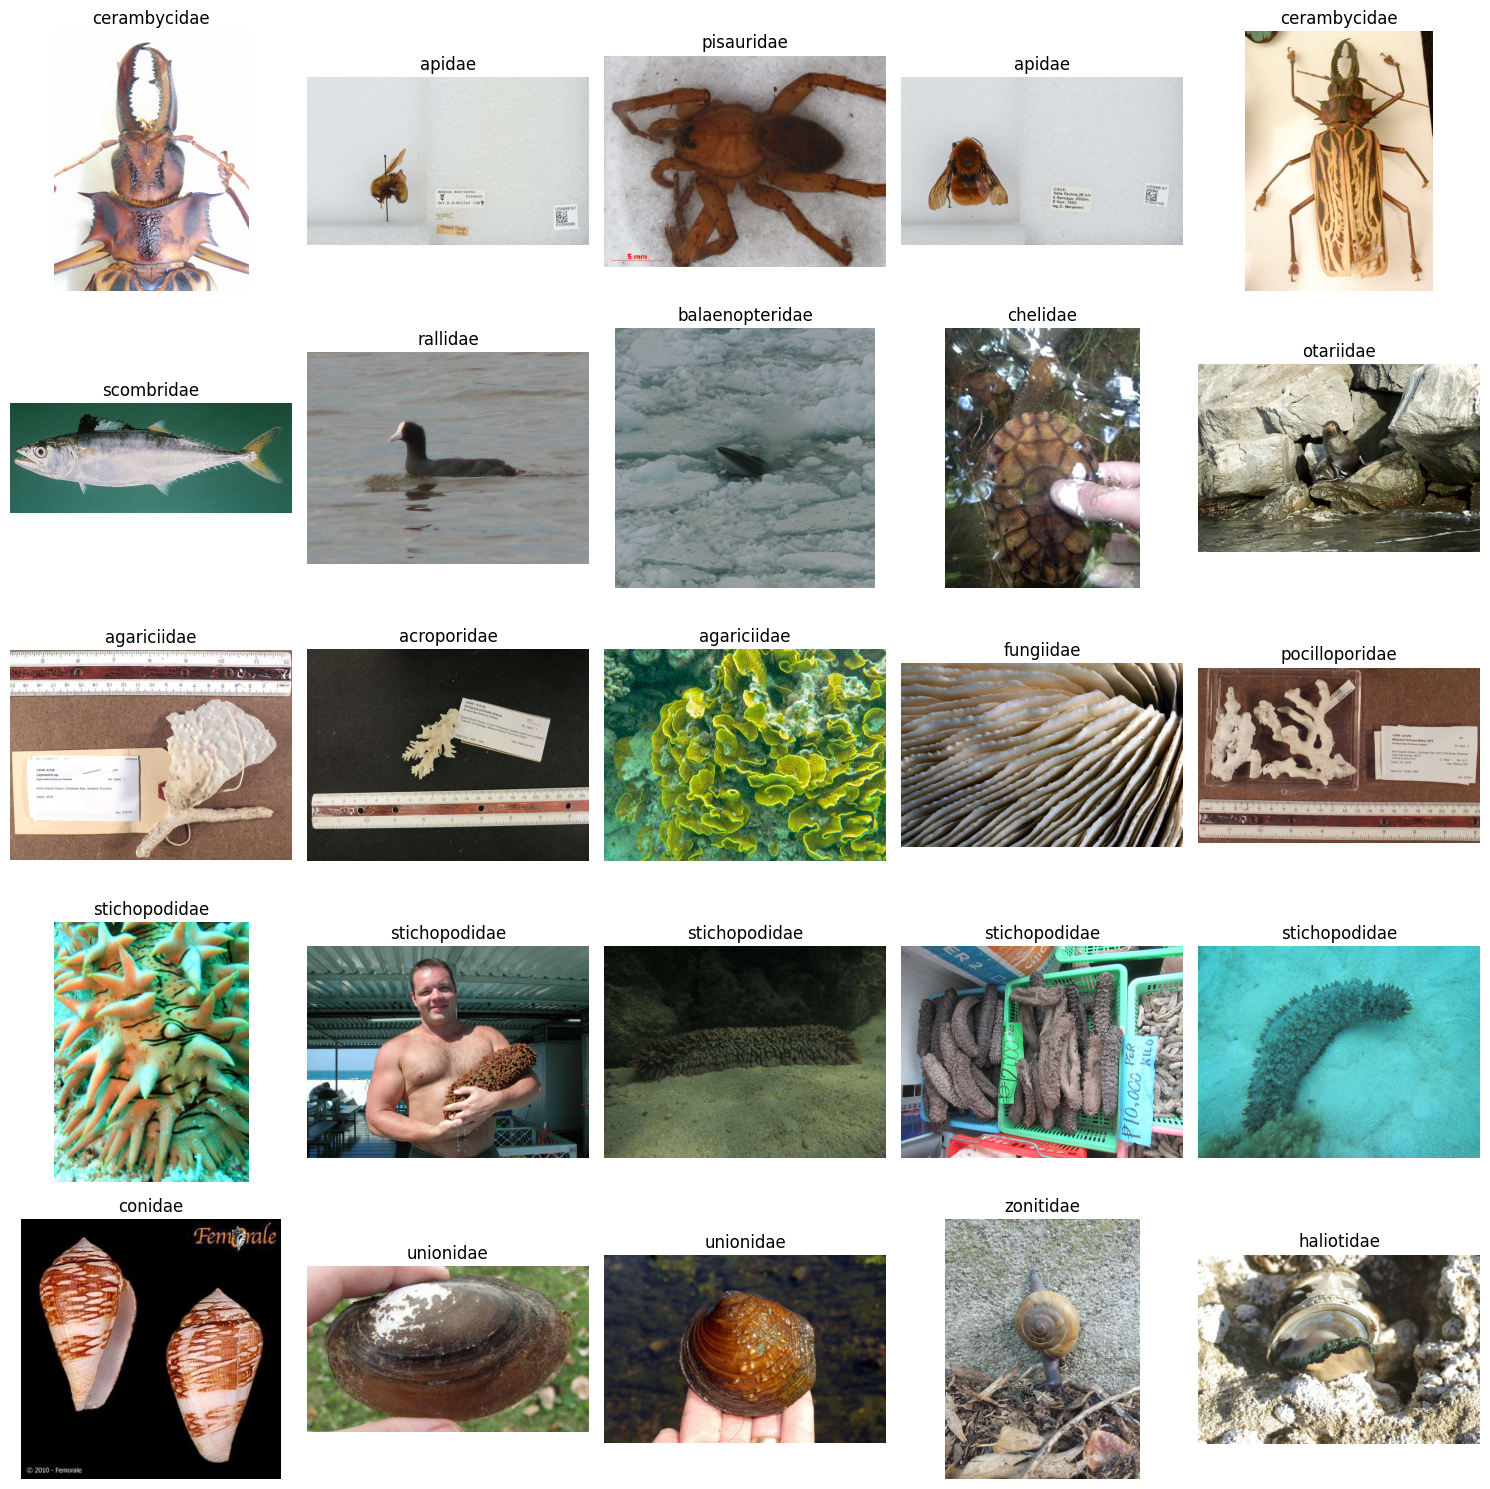

In [25]:
def show_sample_images_by_phylum(df, image_folder, num_samples=5, figsize=(15, 15)):
    '''
    Display sample images for each phylum in a grid. 5 random samples for each phylum.
    
    Parameters:
    df (DataFrame): The DataFrame containing the metadata and image paths.
    image_folder (str): The folder containing the image files.
    num_samples (int, optional): Number of images to display for each phylum. Default is 5.
    figsize (tuple, optional): The size of the figure. Default is (15, 15).
    
    Returns:
    None (displays the plot)
    '''
    # Group by phylum and sample `num_samples` images from each phylum
    phylum_groups = df.groupby('phylum')
    
    # Determine the number of rows and columns for the grid
    num_phyla = len(phylum_groups)
    rows = num_phyla
    cols = num_samples
    
    # Create a figure with a grid layout
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    
    # Iterate through each phylum and display images
    for i, (phylum, group) in enumerate(phylum_groups):
        # Sample images for the current phylum
        sample_df = group.sample(min(num_samples, len(group)))
        
        for j, (_, row) in enumerate(sample_df.iterrows()):
            img_path = os.path.join(image_folder, row['file_path'])
            ax = axes[i, j] if num_phyla > 1 else axes[j]
            
            if os.path.exists(img_path):
                image = Image.open(img_path)
                ax.imshow(image)
                ax.set_title(f'{row["family"]}')
            else:
                ax.set_title("Missing Image")
            ax.axis("off")
        
        # Set title for each phylum row
        axes[i, 0].set_ylabel(phylum, fontsize=12, rotation=0, labelpad=30)

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

show_sample_images_by_phylum(df, extract_path, num_samples=5)

#IMPORTANT NOTES
- we need to decide if we actually want to try to predict first the phylum and only then the family because that will change the preprocessing of the image ig
- 0r we can do a general preprocessing like cutting the images, (they have different sizes btw)
- maybe if we go with predicting first the phylum we can also divide by each member the preprocessing of each specie